In [118]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
import json
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score

import torch.utils.data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import os
import pickle
import torch

import warnings
warnings.filterwarnings('ignore')

# pd.set_option('display.max_columns', 500)

In [119]:
lms = pd.read_csv("./LMS_31JAN2019.csv", keep_default_na=False)
customer = pd.read_csv("./Customers_31JAN2019.csv", keep_default_na=False)
train_csv = pd.read_csv("./train_foreclosure.csv", keep_default_na=False)
test_csv = pd.read_csv("./test_foreclosure.csv", keep_default_na=False)
rfdata = pd.read_csv("./RF_Final_Data.csv", keep_default_na=False)

In [120]:
def transformdataset(dataset):
    merged_inner = pd.merge(left=dataset,right=lms, left_on='AGREEMENTID', right_on='AGREEMENTID')
    merged_inner['LOAN_AMT'] = merged_inner['LOAN_AMT'].str.replace(",", "").astype(float)
    merged_inner['NET_DISBURSED_AMT'] = merged_inner['NET_DISBURSED_AMT'].str.replace(",", "").astype(float)

    merged_inner["CURRENT_ROI"].fillna(0,inplace = True)
    merged_inner['CURRENT_ROI'] = merged_inner['CURRENT_ROI'].astype(float)

    merged_inner['CURRENT_TENOR'] = pd.to_numeric(merged_inner["CURRENT_TENOR"].str.strip(), downcast='integer').fillna(0)

    # merged_inner["LAST_RECEIPT_AMOUNT"].fillna(0,inplace = True)
    merged_inner['LAST_RECEIPT_AMOUNT'] = pd.to_numeric(merged_inner['LAST_RECEIPT_AMOUNT'].str.strip(), downcast='float').fillna(0)

    merged_inner['INTEREST_START_DATE'] = pd.to_numeric(merged_inner['LAST_RECEIPT_AMOUNT'], downcast='float').fillna(0)
    

    merged_inner['BALANCE_TENURE'] = merged_inner['BALANCE_TENURE'].str.replace(",", "")
    merged_inner['BALANCE_TENURE'] = pd.to_numeric(merged_inner['BALANCE_TENURE'].str.strip(), downcast='float').fillna(0)

    merged_inner['INTEREST_START_DATE'] = pd.to_datetime(merged_inner['INTEREST_START_DATE']).dt.date
    merged_inner['AUTHORIZATIONDATE'] = pd.to_datetime(merged_inner['AUTHORIZATIONDATE']).dt.date
    merged_inner['AUTHORIZATIONMONTH'] = pd.DatetimeIndex(merged_inner['AUTHORIZATIONDATE']).month.fillna(0)
    merged_inner['AUTHORIZATIONYEAR'] = pd.DatetimeIndex(merged_inner['AUTHORIZATIONDATE']).year.fillna(0)
    
    
    merged_inner['LAST_RECEIPT_DATE'] = pd.to_datetime(merged_inner['LAST_RECEIPT_DATE']).dt.date
    merged_inner['LAST_RECEIPT_MONTH'] = pd.DatetimeIndex(merged_inner['LAST_RECEIPT_DATE']).month.fillna(0)
    merged_inner['LAST_RECEIPT_YEAR'] = pd.DatetimeIndex(merged_inner['LAST_RECEIPT_DATE']).year.fillna(0)
    merged_inner['DPD'] = pd.to_numeric(merged_inner['DPD'].str.strip(), downcast='integer').fillna(0)

    merged_inner["MOB"].fillna(0,inplace = True)
    # merged_inner['MOB'] = pd.to_numeric(merged_inner['MOB'].str.strip(), downcast='integer')

    # merged_inner["NPA_IN_CURRENT_MONTH"].fillna("NA",inplace = True)
    # merged_inner['NPA_IN_CURRENT_MONTH'] = merged_inner['NPA_IN_CURRENT_MONTH'].str.replace("Yes", "1").astype(int)

    merged_inner['NPA_IN_LAST_MONTH'] = merged_inner['NPA_IN_LAST_MONTH'].apply(lambda x: "NA" if x.strip() == '' else x)
    merged_inner['NPA_IN_LAST_MONTH'] = merged_inner['NPA_IN_LAST_MONTH'].str.upper()
    merged_inner['NPA_IN_LAST_MONTH'] = merged_inner['NPA_IN_LAST_MONTH'].str.replace("YES", "0")
    merged_inner['NPA_IN_LAST_MONTH'] = merged_inner['NPA_IN_LAST_MONTH'].str.replace("NPA", "0")
    merged_inner['NPA_IN_LAST_MONTH'] = merged_inner['NPA_IN_LAST_MONTH'].str.replace("NA", "0")
    merged_inner['NPA_IN_LAST_MONTH'] = merged_inner['NPA_IN_LAST_MONTH'].str.replace("#N/", "1")
    merged_inner['NPA_IN_LAST_MONTH'] = pd.to_numeric(merged_inner['NPA_IN_LAST_MONTH'], downcast='integer').fillna(0)

    merged_inner['NPA_IN_CURRENT_MONTH'] = merged_inner['NPA_IN_CURRENT_MONTH'].apply(lambda x: "NA" if x.strip() == '' else x)
    merged_inner['NPA_IN_CURRENT_MONTH'] = merged_inner['NPA_IN_CURRENT_MONTH'].str.upper()
    merged_inner['NPA_IN_CURRENT_MONTH'] = merged_inner['NPA_IN_CURRENT_MONTH'].str.replace("YES", "0")
    merged_inner['NPA_IN_CURRENT_MONTH'] = merged_inner['NPA_IN_CURRENT_MONTH'].str.replace("NPA", "0")
    merged_inner['NPA_IN_CURRENT_MONTH'] = merged_inner['NPA_IN_CURRENT_MONTH'].str.replace("NA", "0")
    merged_inner['NPA_IN_CURRENT_MONTH'] = merged_inner['NPA_IN_CURRENT_MONTH'].str.replace("#N/", "1")
    merged_inner['NPA_IN_CURRENT_MONTH'] = pd.to_numeric(merged_inner['NPA_IN_CURRENT_MONTH'], downcast='integer').fillna(0)

    merged_customer = pd.merge(left=merged_inner,right=customer, left_on='CUSTOMERID', right_on='CUSTOMERID')

    merged_customer['AGE'] = merged_customer['AGE'].apply(lambda x: "0" if x.strip() == '' else x)
    merged_customer['AGE'] = merged_customer['AGE'].astype(int)

    merged_customer['NO_OF_DEPENDENT'] = merged_customer['NO_OF_DEPENDENT'].apply(lambda x: "0" if x.strip() == '' else x)
    merged_customer['NO_OF_DEPENDENT'] = merged_customer['NO_OF_DEPENDENT'].astype(int)

    merged_customer['PRE_JOBYEARS'] = merged_customer['PRE_JOBYEARS'].apply(lambda x: "0" if x.strip() == '' else x)
    merged_customer['PRE_JOBYEARS'] = merged_customer['PRE_JOBYEARS'].astype(int)

    merged_customer['CITY'] = merged_customer['CITY'].apply(lambda x: "NA" if x.strip() == '' else x)
    # merged_lms['CITY'] = merged_lms['CITY'].str.strip()

    #N/A
    merged_customer['POSITION'] = merged_customer['POSITION'].apply(lambda x: "NA" if x.strip() == '' else x)
    merged_customer['OCCUPATION'] = merged_customer['OCCUPATION'].apply(lambda x: "NA" if x.strip() == '' else x)
    merged_customer['PROFESSION'] = merged_customer['PROFESSION'].apply(lambda x: "NA" if x.strip() == '' else x)
    merged_customer['BRANCH_PINCODE'] = merged_customer['BRANCH_PINCODE'].apply(lambda x: "NA" if x.strip() == '#N/A' else x)

    # merged_lms = merged_customer
    merged_lms = pd.merge(left=merged_customer,right=rfdata, left_on='AGREEMENTID', right_on='Masked_AgreementID')
    merged_lms = merged_lms.drop(['Preprocessed_EmailBody'],axis=1)
    merged_lms = merged_lms.drop(['Preprocessed_Subject'],axis=1)
    # merged_customer['NO_OF_DEPENDENT'] = pd.to_numeric(merged_inner['NO_OF_DEPENDENT'].str.strip(), downcast='integer').fillna(0)
    # merged_customer['PRE_JOBYEARS'] = pd.to_numeric(merged_inner['PRE_JOBYEARS'].str.strip(), downcast='integer').fillna(0)
    # merged_lms['CITY'] = merged_lms['CITY'].apply(lambda x: "NA" if x.strip() == '' else x)
    # merged_lms['CITY'] = merged_lms['CITY'].str.strip()

    merged_lms['Date'] = pd.to_datetime(merged_lms['Date']).dt.date
    # merged_lms['QUALIFICATION'] = merged_lms['QUALIFICATION'].apply(lambda x: "NA" if x.strip() == '' else x)

    merged_lms['SubType'] = merged_lms['SubType'].apply(lambda x: "NA" if x.strip() == '' else x)
    merged_lms['SubType'] = merged_lms['SubType'].str.strip()
    merged_lms['SubType'] = merged_lms['SubType'].str.replace(" ", "")
    merged_lms['SubType'] = merged_lms['SubType'].str.upper()
    merged_lms['Type'] = merged_lms['Type'].apply(lambda x: "NA" if x.strip() == '' else x)
    merged_lms['Status'] = merged_lms['Status'].apply(lambda x: "NA" if x.strip() == '' else x)
    return merged_lms

In [121]:
train = transformdataset(train_csv)
test = transformdataset(test_csv)

In [122]:
pickle.dump((train, test), open('testtrain.p', 'wb'))

In [123]:
train, test = pickle.load(open('testtrain.p', mode='rb'))

In [124]:
display(train.head())

,AGREEMENTID,FORECLOSURE,CUSTOMERID,LOAN_AMT,NET_DISBURSED_AMT,INTEREST_START_DATE,CURRENT_ROI,ORIGNAL_ROI,CURRENT_TENOR,ORIGNAL_TENOR,...,PRE_JOBYEARS,NETTAKEHOMEINCOME,BRANCH_PINCODE,TicketId,Type,SubType,Status,Date,Masked_CustomerID,Masked_AgreementID
0,11220025,1,12001024,2166501.95,2166501.95,1970-01-01,14.0,10.6,0.0,240,...,2,49542.7614,400070,11526,REQUEST,COPYOFORIGDOCS,Close,2016-05-31,12001002,11220025
1,11220025,1,12001024,2166501.95,2166501.95,1970-01-01,14.0,10.6,0.0,240,...,2,49542.7614,400070,122256,REQUEST,FINALITCERTIFICATE,Close,2017-11-09,12001002,11220025
2,11220025,1,12001024,2166501.95,2166501.95,1970-01-01,14.0,10.6,0.0,240,...,2,49542.7614,400070,11526,REQUEST,COPYOFORIGDOCS,Close,2016-05-31,12001002,11220025
3,11220025,1,12001024,2166501.95,2166501.95,1970-01-01,14.0,10.6,0.0,240,...,2,49542.7614,400070,122256,REQUEST,FINALITCERTIFICATE,Close,2017-11-09,12001002,11220025
4,11220025,1,12001024,2166501.95,2166501.95,1970-01-01,14.0,10.6,0.0,240,...,2,49542.7614,400070,11526,REQUEST,COPYOFORIGDOCS,Close,2016-05-31,12001002,11220025


In [125]:
print(train.dtypes)

AGREEMENTID                int64
FORECLOSURE                int64
CUSTOMERID                object
LOAN_AMT                 float64
NET_DISBURSED_AMT        float64
INTEREST_START_DATE       object
CURRENT_ROI              float64
ORIGNAL_ROI              float64
CURRENT_TENOR            float64
ORIGNAL_TENOR              int64
DUEDAY                     int64
AUTHORIZATIONDATE         object
CITY                      object
PRE_EMI_DUEAMT           float64
PRE_EMI_RECEIVED_AMT     float64
PRE_EMI_OS_AMOUNT        float64
EMI_DUEAMT               float64
EMI_RECEIVED_AMT         float64
EMI_OS_AMOUNT            float64
EXCESS_AVAILABLE         float64
EXCESS_ADJUSTED_AMT      float64
BALANCE_EXCESS           float64
NET_RECEIVABLE           float64
OUTSTANDING_PRINCIPAL    float64
PAID_PRINCIPAL           float64
PAID_INTEREST            float64
MONTHOPENING             float64
LAST_RECEIPT_DATE         object
LAST_RECEIPT_AMOUNT      float32
NET_LTV                  float64
          

In [126]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+', num, 'numerical', '=', cat+num, 'features')

Total Features:  18 categorical + 42 numerical = 60 features


In [127]:
cols_label = ('PRODUCT','POSITION','OCCUPATION', 'Status', 'SubType')
for c in cols_label:
    lbl = LabelEncoder() 
    # lbl.fit(list(train[c].values))
    lbl.fit(list(np.concatenate((train[c].values, test[c].values), axis=None))) 
    train[c] = lbl.transform(list(train[c].values))
    test[c] = lbl.transform(list(test[c].values))

In [128]:
def DropColumns(merged_lms):
    #merged_lms = merged_lms.drop(['EXCESS_AVAILABLE'],axis=1)
    #merged_lms = merged_lms.drop(['EXCESS_ADJUSTED_AMT'],axis=1)
    #merged_lms = merged_lms.drop(['NET_RECEIVABLE'],axis=1)
    merged_lms = merged_lms.drop(['INTEREST_START_DATE'],axis=1)
    merged_lms = merged_lms.drop(['AUTHORIZATIONDATE'],axis=1)
    merged_lms = merged_lms.drop(['LAST_RECEIPT_DATE'],axis=1)
    # merged_lms = merged_lms.drop(['Status'],axis=1)
    #merged_lms = merged_lms.drop(['CURRENT_TENOR'],axis=1)
    #merged_lms = merged_lms.drop(['COMPLETED_TENURE'],axis=1)
    #merged_lms = merged_lms.drop(['NETTAKEHOMEINCOME'],axis=1)
    #merged_lms = merged_lms.drop(['NET_DISBURSED_AMT'],axis=1)
    #merged_lms = merged_lms.drop(['PRE_EMI_RECEIVED_AMT'],axis=1)
    #merged_lms = merged_lms.drop(['PRE_EMI_DUEAMT'],axis=1)
    #merged_lms = merged_lms.drop(['OUTSTANDING_PRINCIPAL'],axis=1)
    #merged_lms = merged_lms.drop(['LOAN_AMT'],axis=1)
    #merged_lms = merged_lms.drop(['PAID_INTEREST'],axis=1)
    #merged_lms = merged_lms.drop(['EMI_RECEIVED_AMT'],axis=1)
    #merged_lms = merged_lms.drop(['EMI_DUEAMT'],axis=1)
    #merged_lms = merged_lms.drop(['ORIGNAL_ROI'],axis=1)
    merged_lms = merged_lms.drop(['AGREEMENTID'],axis=1)
    merged_lms = merged_lms.drop(['CUST_CONSTTYPE_ID'],axis=1)
    merged_lms = merged_lms.drop(['Masked_AgreementID'],axis=1)
    merged_lms = merged_lms.drop(['Masked_CustomerID'],axis=1)
    merged_lms = merged_lms.drop(['TicketId'],axis=1)
    merged_lms = merged_lms.drop(['BRANCH_PINCODE'],axis=1)
    return merged_lms
# merged_lms = merged_lms.drop(['AGE'],axis=1)

In [129]:
train = DropColumns(train)

35
Index(['FORECLOSURE', 'LOAN_AMT', 'CURRENT_ROI', 'ORIGNAL_ROI',
       'CURRENT_TENOR', 'ORIGNAL_TENOR', 'DUEDAY', 'PRE_EMI_DUEAMT',
       'PRE_EMI_OS_AMOUNT', 'EMI_DUEAMT', 'EMI_OS_AMOUNT', 'EXCESS_AVAILABLE',
       'BALANCE_EXCESS', 'PAID_PRINCIPAL', 'LAST_RECEIPT_AMOUNT', 'NET_LTV',
       'COMPLETED_TENURE', 'DPD', 'FOIR', 'PRODUCT', 'NPA_IN_LAST_MONTH',
       'NPA_IN_CURRENT_MONTH', 'AUTHORIZATIONMONTH', 'AUTHORIZATIONYEAR',
       'LAST_RECEIPT_MONTH', 'LAST_RECEIPT_YEAR', 'CUST_CATEGORYID', 'AGE',
       'NO_OF_DEPENDENT', 'OCCUPATION', 'POSITION', 'GROSS_INCOME',
       'PRE_JOBYEARS', 'SubType', 'Status'],
      dtype='object')


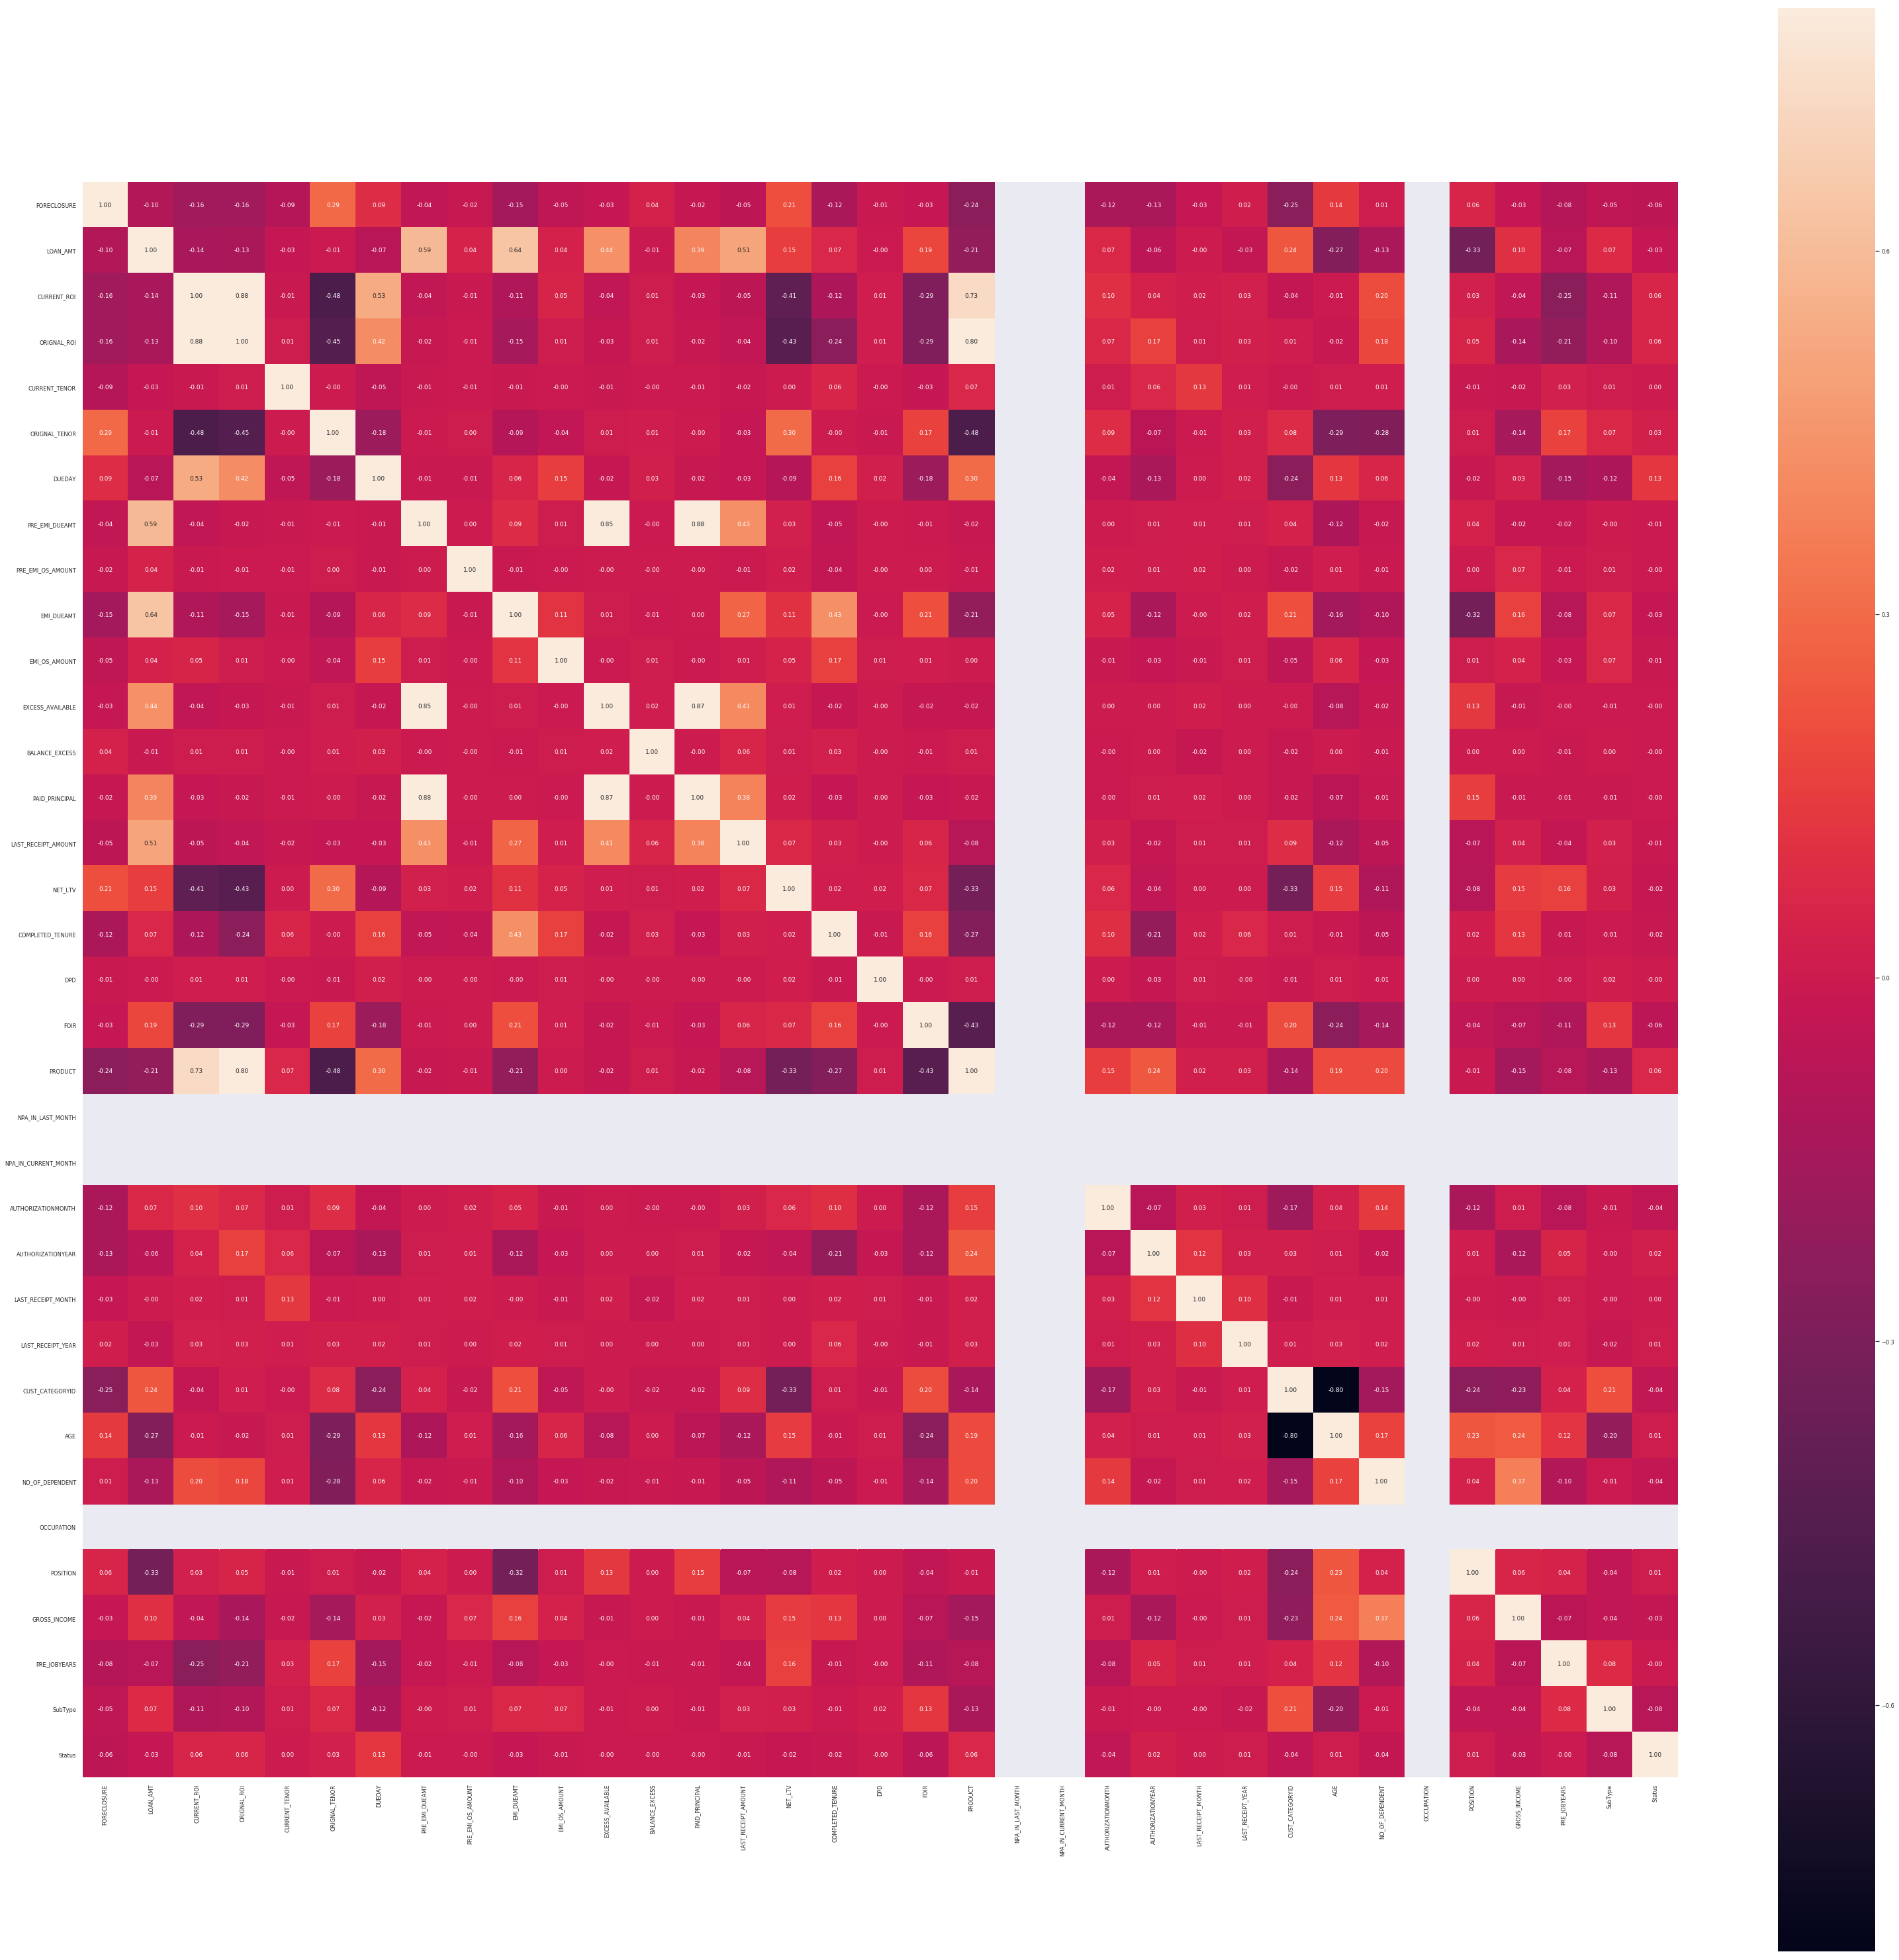

In [130]:
# train = train.iloc[:,1:-1]
corr = train.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
selected_columns = []
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.89:
            if columns[j]:
                columns[j] = False
                # selected_columns.append(columns[j])

selected_columns = corr.columns[columns]
print(len(selected_columns))
print(selected_columns)
data = train[selected_columns]
f, ax = plt.subplots(figsize=(54, 54))
sns.set(font_scale=0.75)
sns.heatmap(data.corr(), cbar=True, annot=True, square=True, vmax=.8, fmt='.2f', yticklabels=selected_columns, xticklabels=selected_columns)
plt.show()

# data = data[selected_columns]

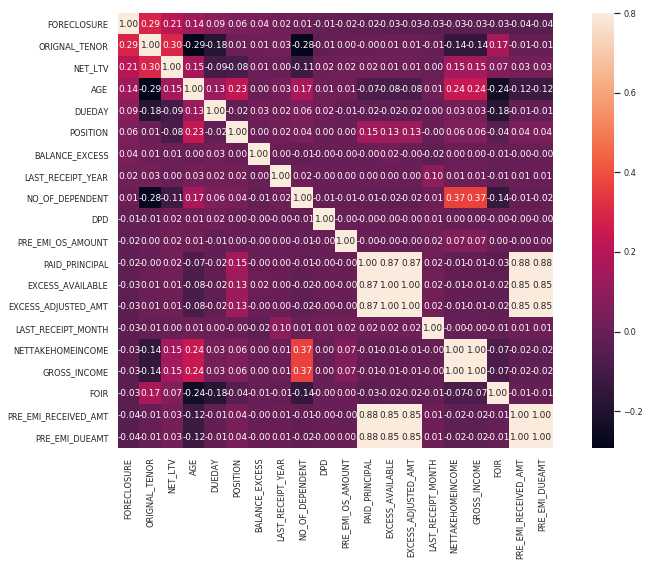

In [31]:

k = 20
corrmat = train.corr()
cols = corrmat.nlargest(k, 'FORECLOSURE')['FORECLOSURE'].index
cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize=(14, 8))
sns.set(font_scale=0.75)
sns.heatmap(cm, cbar=True, annot=True, square=True, vmax=.8, fmt='.2f', yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [123]:
trimed_train = pd.DataFrame(columns=cols.values)
trimed_test = pd.DataFrame(columns=cols.values)
for c in cols.values:
    trimed_train[c] = train[c]
    trimed_test[c] = test[c]

# trimed_train = pd.concat([trimed_train, trimed_train], ignore_index=True)
trimed_test = trimed_test.drop('FORECLOSURE',axis = 1)
col_train = list(cols)
col_train_bis = list(cols)

col_train_bis.remove('FORECLOSURE')
print(len(col_train))
print(trimed_train.shape)

4
(11997, 4)


In [124]:
display(trimed_train.head())

,FORECLOSURE,ORIGNAL_TENOR,NET_LTV,AGE
0,1,240,84.96,28
1,1,240,84.96,28
2,1,240,84.96,28
3,1,240,84.96,28
4,1,240,84.96,28


In [125]:

mat_train = np.matrix(trimed_train)
mat_test  = np.matrix(trimed_test)

mat_new = np.matrix(trimed_train.drop('FORECLOSURE',axis = 1))
mat_y = np.array(trimed_train.FORECLOSURE).reshape((11997,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train_set = pd.DataFrame(prepro.transform(trimed_train),columns = col_train)

# test = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

test_set  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

display(train_set.head())


,FORECLOSURE,ORIGNAL_TENOR,NET_LTV,AGE
0,1.0,0.75,1.0,0.474576
1,1.0,0.75,1.0,0.474576
2,1.0,0.75,1.0,0.474576
3,1.0,0.75,1.0,0.474576
4,1.0,0.75,1.0,0.474576


In [126]:
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "FORECLOSURE"

# Training set and Prediction set with the features to predict
training_set = train_set[COLUMNS]
prediction_set = training_set.FORECLOSURE

# print(prediction_set)

X_train, X_val, y_train, y_val = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.4)

train_set_tensor = torch.utils.data.TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values))
val_set = torch.utils.data.TensorDataset(torch.FloatTensor(X_val.values), torch.FloatTensor(y_val.values))

batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set_tensor,batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size)

# test_loader = torch.utils.data.DataLoader(torch.FloatTensor(test.values),batch_size=batch_size)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [127]:
# print(X_train)

In [128]:
# Hyperparameters
batch_no = len(X_train) // batch_size  #batches
cols=X_train.shape[1] #Number of columns in input matrix
n_output=1

# Sequence Length
sequence_length = 6  # of words in a sequence 892110
# Batch Size
# batch_size = 128
# train_loader = batch_data(int_text, sequence_length, batch_size)
# Number of Epochs
num_epochs = 1000
# Learning Rate
learning_rate = 0.002
# Model parameters
# Input size
input_size = cols
# Output size
output_size = 1
# Embedding Dimension
embedding_dim = 128
# Hidden Dimension
hidden_dim = 256
# Number of RNN Layers
n_layers = 2

# Show stats for every n number of batches
show_every_n_batches = 50

In [129]:
# sns.pairplot(train);

In [130]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    """
    This is the simple RNN model we will be using to perform Sentiment Analysis.
    """

    def __init__(self, embedding_dim, hidden_dim, input_size, n_layers, output_size, dropout=0.5):
        """
        Initialize the model by settingg up the various layers.
        """
        super(LSTMClassifier, self).__init__()

        # self.embedding = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.dense = nn.Linear(in_features=hidden_dim, out_features=output_size)
        self.sig = nn.Sigmoid()        
        # self.word_dict = None
        
        # self.fc1 = nn.Linear(input_size, hidden_dim * 2)
        # self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        # self.fc3 = nn.Linear(hidden_dim, output_size)
        # self.dropout = nn.Dropout(p=0.25)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.08
        # self.embedding.weight.data.uniform_(-initrange, initrange)
        self.lstm.weight_ih_l0.data.uniform_(-initrange, initrange)
        self.lstm.weight_hh_l0.data.uniform_(-initrange, initrange)
        
        self.lstm.bias_ih_l0.data.zero_()
        self.lstm.bias_hh_l0.data.zero_()
        
        # self.fc.bias.data.zero_()
        self.dense.bias.data.fill_(0)
        # self.fc.weight.data.uniform_(-initrange, initrange)
        self.dense.weight.data.normal_(0.0, (1.0 / np.sqrt(self.dense.in_features)))
        
    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        batch_size = x.size(0)
        # print(x.shape)
        # x = x.permute(14, 32)
        # x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        # x = F.relu(self.fc2(x))
        # x = self.dropout(x)
        # out = self.fc3(x)
        # x = x.permute(2, 0, 1)
        # print(batch_size)
        # print(x.shape)
        # x = x.t()
        # embeds = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        # avg_pool_l = torch.mean(lstm_out.permute(1, 0, 2), 1)
        # max_pool_l, _ = torch.max(lstm_out.permute(1, 0, 2), 1)
        # print(avg_pool_l)
        # x = torch.cat((avg_pool_l, max_pool_l), 1)
        # print(x.shape)
        out = self.dense(lstm_out)
        # out = self.sig(out.squeeze())
        # print(out)
        # out = out[lengths - 1, range(len(lengths))]
        return out

In [131]:
from torch.autograd import Variable

def forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden_dim, clip=9):

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    hidden = {}
    # hidden = tuple([each.data for each in hidden_dim])
    
    rnn.zero_grad()
    optimizer.zero_grad()
    
    try:
        # get the output from the model
        # output, hidden = rnn(inputs, hidden)
        output = rnn(inputs.unsqueeze(0))
        output = output.squeeze()
        # print(output.shape)
    except RuntimeError:
        raise
    # print(labels)
    loss = criterion(output, labels)
    loss.backward()
    
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(rnn.parameters(),  clip)
   
    optimizer.step()

    return loss.item(), hidden

In [132]:
def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    batch_losses = []
    val_batch_losses = []
    valid_loss_min = np.Inf
    
    rnn.train()
    
    previousLoss = np.Inf
    minLoss = np.Inf

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # initialize hidden state
        # hidden = rnn.init_hidden(batch_size)
        hidden = {}
        # print("epoch ",epoch_i)
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            # batch_last = batch_i
            # n_batches = len(train_loader.dataset) // batch_size
            
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden, clip=5)          
            # record loss
            batch_losses.append(loss)
            
        for batch_i, (inputs, labels) in enumerate(val_loader, 1):
            # batch_last = batch_i
            # n_batches = len(val_loader.dataset) // batch_size
            # if(batch_i > n_batches):
                # break
            
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden, clip=5)          
            # record loss
            val_batch_losses.append(loss)

        # printing loss stats
        if epoch_i%show_every_n_batches == 0:
            average_loss = np.average(batch_losses)
            val_average_loss = np.average(val_batch_losses)
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch_i, average_loss, val_average_loss))

            ## TODO: save the model if validation loss has decreased
            # save model if validation loss has decreased
            if val_average_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                val_average_loss))
                with open('./save/trained_rnn_new', 'wb') as pickle_file:
                    # print(pickle_file)
                    torch.save(rnn, pickle_file)
                valid_loss_min = val_average_loss

            batch_losses = []
            val_batch_losses = []
            
    return rnn

In [133]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

In [134]:
# create model and move to gpu if available
# rnn = RNN(input_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.25)
# rnn.apply(weight_init)
rnn = LSTMClassifier(embedding_dim, hidden_dim, input_size, n_layers, output_size)
# rnn = torch.load("./save/trained_rnn_new")

if train_on_gpu:
    rnn.cuda()

decay_rate = learning_rate / num_epochs

# print(decay_rate)
# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9, weight_decay=decay_rate)

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss(size_average=False)
# rnn = helper.load_model('./save/trained_rnn_new')

# training the model
trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
# helper.save_model('./save/trained_rnn', trained_rnn)
print('Model Trained and Saved')

Training for 1000 epoch(s)...
Epoch: 50 	Training Loss: 0.824234 	Validation Loss: 0.754356
Validation loss decreased (inf --> 0.754356).  Saving model ...
Epoch: 100 	Training Loss: 0.451187 	Validation Loss: 0.266739
Validation loss decreased (0.754356 --> 0.266739).  Saving model ...
Epoch: 150 	Training Loss: 0.295157 	Validation Loss: 0.134988
Validation loss decreased (0.266739 --> 0.134988).  Saving model ...
Epoch: 200 	Training Loss: 0.236548 	Validation Loss: 0.097996
Validation loss decreased (0.134988 --> 0.097996).  Saving model ...
Epoch: 250 	Training Loss: 0.207356 	Validation Loss: 0.081452
Validation loss decreased (0.097996 --> 0.081452).  Saving model ...
Epoch: 300 	Training Loss: 0.187168 	Validation Loss: 0.070505
Validation loss decreased (0.081452 --> 0.070505).  Saving model ...
Epoch: 350 	Training Loss: 0.170950 	Validation Loss: 0.062496
Validation loss decreased (0.070505 --> 0.062496).  Saving model ...
Epoch: 400 	Training Loss: 0.152351 	Validation Loss

KeyboardInterrupt: 

In [135]:
def predict(model, inputs):

    if(train_on_gpu):
        inputs = inputs.cuda()
    
    try:
        output = model(inputs.unsqueeze(0))
        output = output.squeeze()
    except RuntimeError:
        raise
    
    # prediction = np.array(output).argmax(0)
    # p = F.softmax(output, dim=1).data
    # p = F.sigmoid(output)
    # p = F.logsigmoid(output)
    p = output.cpu().detach().numpy().flatten()
    # print(p)
    # prediction = np.argmax(p)
    # print(prediction)
    return p

In [136]:
model_rnn = torch.load("./save/trained_rnn_new")
model_rnn.eval()

X = Variable(torch.FloatTensor(X_train.values)) 
pred = predict(model_rnn, X)
print(pred[:30])
# pred= result
print(y_train.values[:30])
r2_score(y_train.values, pred)

# probs = probs[:, 1]
# calculate AUC
# auc = roc_auc_score(y_train, pred)
# print('AUC: %.3f' % auc)
# calculate roc curve
# fpr, tpr, thresholds = roc_curve(y_train, pred)
# plot no skill
# pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
# pyplot.plot(fpr, tpr, marker='.')
# show the plot
# pyplot.show()


[-0.00260043 -0.07568491  1.0117216  -0.04977807 -0.01294674  0.9999275
 -0.00453372 -0.00675122  0.95033056  1.001414   -0.01049785 -0.02632409
 -0.00538652  0.01057388 -0.00773332 -0.04310954  0.9934097  -0.04943016
  1.1278787   0.00158867 -0.0131983   0.8783683  -0.00471821  0.9870368
  0.9735907  -0.02707057 -0.01917389 -0.00789724  0.8967064  -0.01677656]
[0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 1. 0.]


0.9585744115607087

## Test Prediction

In [137]:
display(test_set.head())

,ORIGNAL_TENOR,NET_LTV,AGE
0,0.5,0.454678,0.728814
1,0.5,0.454678,0.728814
2,0.5,0.454678,0.728814
3,0.5,0.454678,0.728814
4,0.5,0.454678,0.728814


In [138]:
test_X = Variable(torch.FloatTensor(test_set.values))
print(test_X)
test_pred = predict(model_rnn, test_X)
print(test_pred)
print(len(test_pred))
# print(np.array(test_p).reshape(9614,1))

tensor([[0.5000, 0.4547, 0.7288],
        [0.5000, 0.4547, 0.7288],
        [0.5000, 0.4547, 0.7288],
        ...,
        [0.5000, 0.2484, 0.4746],
        [0.5000, 0.2484, 0.4746],
        [0.5000, 0.2484, 0.4746]])
[-0.005017   -0.05389732 -0.0530749  ...  0.7740859   0.7739967
  0.7739073 ]
8037


In [141]:
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(test_pred).reshape(8037,1)), columns = ["FORECLOSURE"])
# predictions = pd.DataFrame(np.array(test_pred).reshape(8037,1), columns = ["FORECLOSURE"])
# predictions["FORECLOSURE"] = predictions["FORECLOSURE"]
predictions['FORECLOSURE'] = predictions['FORECLOSURE'].apply(lambda x: 0 if x < 0 else x)
# predictions['FORECLOSURE'] = predictions['FORECLOSURE'].apply(lambda x: 0 if x < 0.01 else 1)
# predictions['FORECLOSURE'] = predictions['FORECLOSURE'].apply(lambda x: 1 if x > 0 else x)
# predictions = predictions.round(2)
predictions["AGREEMENTID"] = test_csv["AGREEMENTID"]
display(predictions.head())

,FORECLOSURE,AGREEMENTID
0,0.0,11220003
1,0.0,11220004
2,0.0,11220005
3,0.0,11220007
4,0.0,11220009


In [142]:
predictions.to_csv("output_final_3.csv")